In [2]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# The Difference-in-Diferences Saga

After discussing treatment effect heterogeneity, we will now switch gears a bit, back into average treatment effects. Over the next few chapters, we will cover some recent developments in panel data methods. To motivate that, we will mostly talk about causal inference applications to marketing. Markting is particurlaly interesting for its notorious dificulty in runing randomized experience. In marketing, we often can't control who recieves the treatment, that is, who sees our advertisements. When a new user comes to our site or downloads our app, we have no good way of knowing if that user came because he or she saw one of our campaings or due to some other factor. (OBS: For those more familiar with marketing attribution, I'm aware of the many attribution tools that aims at solving this problem. But I'm also aware of their many limitations). Because of that, a common practice is Geo-Experiments: we deploy a marketing campaing to some geografical region but not others and compare them. In this design panel data methods are very promissing. Particularly popular among those is the Diff-in-Diff (DiD) method.

The years 2020 and 2021 have not been easy for most of us. But it was a particularly hard for DiD. A lot of recent research hilighted some severe flaws in this method, which was not well known in the past. So, although we already have a chapter in Part I covering DiD, that chapter does not cover the new findings, problems and solutions. Hence, we will try to make sense of the recent DiD revolution covering in 3 acts:

1. **Promise**: Recap why panel data is so attractive for causal inference and how DiD leverages the temporal structure in its favor. 
2. **Death**: Digest the assumptions implied by DiD and Two Way Fixed Effect models and where and why they can fail.  
3. **Elightment**: Understand which assumptions in the previous act can be relaxed and which ones can't. By doing so, we should have a clear picture on where we can use DiD and where do we need other methods.


## 1) The Promise of Panel Data


Panel data is when we have multiple units `i` over multiple periods of time `t`. Think about a policy evaluation scenario in the US, where you want to check the effect of cannabis legalization on crime rate. You have crime rate data on multiple states `i` over multiple time perios `t`. You also observe at what point in time each state adopts legislation in the direction of canabis legalization. I hope you can see why this is incredibly powerfull for causal inference. Call canabis legalization the treatment `D` (since `T` is taken; it represents time). We can follow the trend on crime rates for a particular state that eventually gets treated and see if there are any disruptions in the trend at the treatment time. In a way, a state serves as its own control unit, in a sort of before and after comparisson. Furthermore, becase we have multiple states, we can also compare treated states to control states. When we put both comparissons toguether, treated vs control and before and after treatement, we end up with an incredibly powerfull tool to infer counterfactuals and, hence, causal effects. 

Panel data methods are often used in govenment policy evaluation, but we can easily make an argument about why it is also incredibly usefull for the (tech) industry. Companies often track user data across multiple periods of time, which results in a rich panel data structure. To expore that idea further, let's consider a hypothetical example of a young tech company that traks its install across multiplies cities. At some point in 2021, the tech company lounched a new feature and it wants how many new uses that feature brought to the company. The rolout was gradual. Some cities got the feature in `2021-06-01`. Others, in `2021-07-15`. The full rolot to the rest of the cities only hapened in 2022. Since our data only goes up untill `2021-07-31`, this last groups can be considered the control. In causal inference terms, roling out a feature is the treatment and each of the three groups (treated in `2021-06-01`, treated in `2021-07-15` and control) is called a cohort. A cohort is simply a bunch of units that got treated at the same time period. To get a sense of what this data looks like, lets plot daily installs grouped by cohort.

In [33]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"])
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    post = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    treat_post = lambda d: d["treat"]*d["post"],
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat_post"] == 1, d["y1"], d["y0"])
)


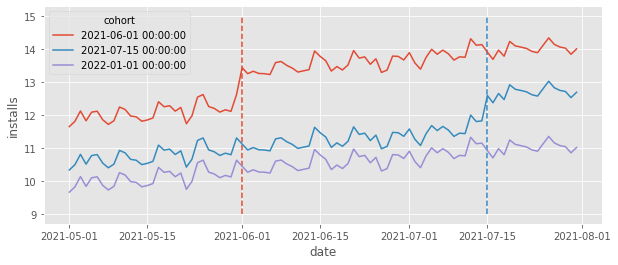

In [34]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

The dashed lines mark the moment a cohort got the treatment (the feature was roled out) Take a momen to appreciate the richness of the data depicted in the above plot. First, we can see that each cohort have its own baseline level. Thats simply because different cities have different population sizes, leading to more or less installs acordingly. For instance, it looks like cities in the first cohort (treated in 06/01) have a higher baseline, compared to the other cohorts. Also, it looks like the control have a lower baseline installs. This means that simply comparing treated cohorts to control cohorts would yield a biased result, since $Y_{0}$ for the control is lower than the $Y_{0}$ for the treated. Fortunatly, panel data allow us to compare acorss cities **and** time.

Speaking of time, notice how there is an overall upward trend with some wigles (which look like weekly seasonality). Looking at the control, it looks like daily installs went from about 10 in May to about 11 in Jun, a increase in about 1 unit. In technical terms, latter time periods have higher $Y_{0}$ than early time periods. So, simply comparing the same cities across time would also yield in biased results. Once again, we are fortunate that the pannel data structure allow us to compare not only across time, but also across cities. 

Ideally, to infer the effect of the feature rolout, we want is to know what would have happened to the cohorts that that got the feature, had they not get it. We want to estimate the counterfactual outcome $Y(0)$ in the post treatment periods. If we denote each cohort by the time it got treated `g` (remember that a cohort is just a group of cities that got treated at the same time), we can write this counterfactual as $E[Y_0|t\geq g]$, which would then allow us to estimate the treatment effect on the treated (the ATT) for cohort `g` as folows:

$$
E[Y_1|t \geq g] - E[Y_0|t\geq g]
$$


Well, one way we can exploit the power of the panel data structure and estimate those counterfactuals if by using linear regression and the Diff-in-Diff formulation we get using a Two Way Fixed Effect model. Let's say each city `i` has a base install level $\gamma_i$. That ties back to what we saw earliers that, maybe a city has more installs because it has a bigger population, or because its culture is more in line with the product from out tech company. Regarthless of the reason and even if we don't know why, we say that those unit idiosincrasies can be captured by a time fixed parameter $\gamma_i$. Similarly, we can say that each time period `t` has a baseline install level which we can capture by a unit fixed parameter $\theta_t$. If that is the case, a good way of modeling install is to say it depends on the city (unit) effect $\gamma$ and the time effect $\theta$, plus some random noise.

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$

To include the treatment in this picture, lets define a variable $D_{it}$ wich is 1 if the unit is treated. In our example, this variable would be always zero for the never treated cohort. It would also be zero for all the other cohorts at the begining, but it would turn into 1 at 06/01 for the cohort treated in 06/01 and stay on after that. Also, it would turn into 1 at 07/15 for the cohort treated in 07/15. We can include those treatment indicators in our model of installs as follows:

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

Estimating the above model is OLS is what is called the Two-Way Fixed Effects Models (TWFE). Notice that $\tau$ would be the treatment effect, as it tells us how much installs changes once units are treated.


Another way of looking at it is to invoke the "holding things constant" propriety of linear regression. If we estimate the above model, we could read the estimate of $\tau$ as how much installs would change if we flip the treatment from 0 to 1 while holding the unit `i` and time `t` fixed. Take a minute to appriciate how bold this is! To say we would hold each unit fixed while seeng how $D$ changes the outcome is to say we are controling for all unit specific characteristic, known and unknown. For example, we would be controling for cities baseline install level, wich we could measure, but also stuff we have no idea about, like how much a city culture is in line with our produt... The only requirement is that this caracteristic is fixed over the time of the analysis. Moreover, to say we would hold each time period fixed is to say we are controlling for all year specifit characteristic. For instance, since we are holding year fixed, while looking at the effect of $D$, that trend and seasonalities we saw earlies would vanish.

To see all this power in action all we have to do is run an OLS model with the treatment indicator $D$ (`treat_post` here), plus dummies for the units and time. In our particular example, I've generated data in such a way that the effect of the treatment (new feature) is to increase installs by 1. Notice how TWFE nais in recovering that treatment effect perfectly:

In [35]:
formula = f"""installs ~ treat_post + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat_post"]

1.0000000000000533

Since I've simulated the data above, I know exactly the true individual treatment effect, which is stored in the `tau` column. Since the TWFE should recover the treatment effect on the treated, we can verify that the true ATT matches the one estimated above. 

In [36]:
df.query("treat_post==1")["tau"].mean()

1.0

Before anyone comes and say that generating one dummy column for each unit is impossible with big data, let me come foreward and tell you that, yes, that is true. But there is a easy work around. We can use the FWL theorem to partition that single regression into two. In fact, runing the above model is numerically equivalent to estimating the following model

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$

where 

$$
\tilde{Sales}_{it} = Sales_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Sales_{it}}_\text{Time Average} - \underbrace{\frac{1}{N}\sum_{i=0}^N Sales_{it}}_\text{Unit Average}
$$

and

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

In words now, in case the math is too crowded, we subtract the unit average across time (first term) and the time average across units (second term) from both the treatment indicator and the outcome variable to constrict the residuals. This process is often times called de-meaning, since we subtract the mean from the outcome and treatment. Finally, here is the same exact thing, but in code:

In [37]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat_post"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat_post"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,7.98e-16,-1.44e+16,0.000,-11.458,-11.458
treat_post,1.0000,2.02e-15,4.96e+14,0.000,1.000,1.000


Another thing we can do to understand what TWFE model is doing is to plot the counterfactual predictions $\hat{Y_0}|t \geq g$. This is helpfull because what our model sees as the treatment effect $\hat{\tau}$ as simply the estimated difference $Y_1 - \hat{Y_0}$. Looking at this explicit difference can shed some light on what the model is doing. In the plot below, we can see exactly that, $\hat{Y_0}$ represented by dotted lines. 

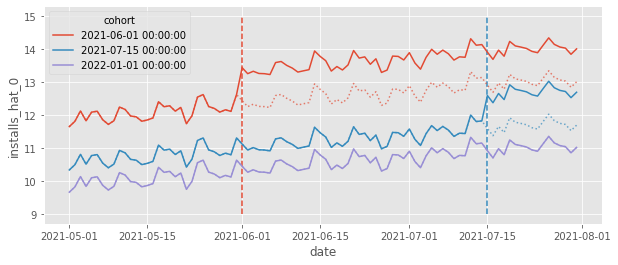

In [38]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat_post":0}))})
          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

This plot shows us how TWFE is projecting the trend it sees in the control units on the treated units and it is also adjusting the levels. For example, if we look at the red cohort, the counterfactual $Y_0$ is the average trend from the blue and purple cohorts (trend projection) but shifted to the level of the red cohort (level adjustment). This is why we see TWFE as a Difference-in-Differences method. It also does the trend projection and level adjustment, but it workd for multiple time periods and multiple units (in the 2 units by 2 period case, both are equivalent). 

As we just saw, DiD and TWFE has its merits. It can estimate counterfactuals quite well, acomodaing both time and unit specifit variation, making it a powerfull causal inference tecnique. I should point out though that, like all generated data, the one we saw here is a lot nicer compared to what we see in reall life. But that is OK, snce simulated data will alow us to explore TWFE in greater detail. We will be able to see how the model behaves to suttle changes in the Data Generating Process, when it works and when it fails.

## 1) Death: Assuptions and It's Failures

## Trend in the Effect

In [7]:
time = range(1980, 2010)
cohorts = [1985,1994,2000,2011]
units = range(1, 100+1)

np.random.seed(3)

df_trend_effect = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
)).assign(
    relative_year = lambda d: d["year"] - d["cohort"],
    trend = lambda d: (d["year"] - d["year"].min())/8,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["unit_fe"] + 0.02*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.2*(np.maximum(0, d["year"] - d["cohort"])), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

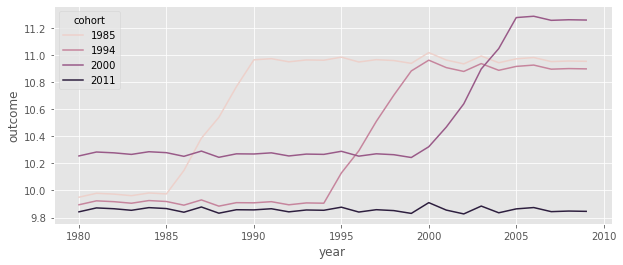

In [8]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_trend_effect.groupby(["cohort", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="cohort",
);

In [9]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_trend_effect)

result = mod.fit()

result.params["treat:post"]

0.6505372592799239

In [10]:
df_trend_effect.query("treat==1 & post==1")["tau"].mean()

0.8293413173652695

### Event Study Desing

In [11]:
relative_years = range(-10,10+1)

formula = "outcome~"+"+".join([f'Q({c})' for c in relative_years]) + "+C(unit)+C(year)"

mod = smf.ols(formula,
              data=(df_trend_effect.join(pd.get_dummies(df_trend_effect["relative_year"]))))

result = mod.fit()

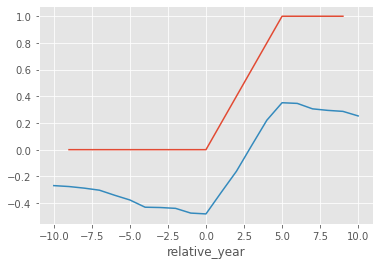

In [12]:
ax = (df_trend_effect
      .query("treat==1")
      .query("relative_year>-10")
      .query("relative_year<10")
      .groupby("relative_year")["tau"].mean().plot())

ax.plot(relative_years, result.params[-len(relative_years):]);

## Covariates

## X-Specific Trends

In [13]:
time = range(1980, 2000)
cohorts = [1990]
units = range(1, 100+1)

np.random.seed(3)

x = np.random.choice(np.random.normal(size=len(units)//10), size=len(units))

df_cov_trend = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
    x = np.repeat(x, len(time)),
)).assign(
    trend = lambda d: d["x"]*(d["year"] - d["year"].min())/20,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = np.repeat(np.random.binomial(1, expit(x)), len(time)),
    y0 = lambda d: 10 + d["trend"] + 0.5*d["unit_fe"] + 0.01*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

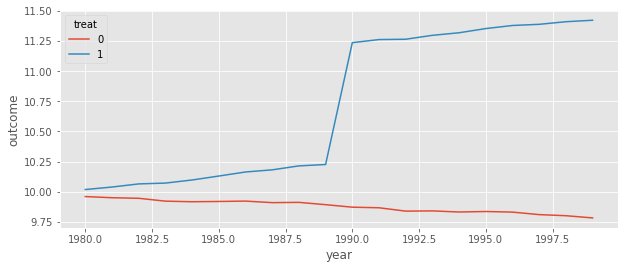

In [14]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_cov_trend.groupby(["treat", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="treat",
);

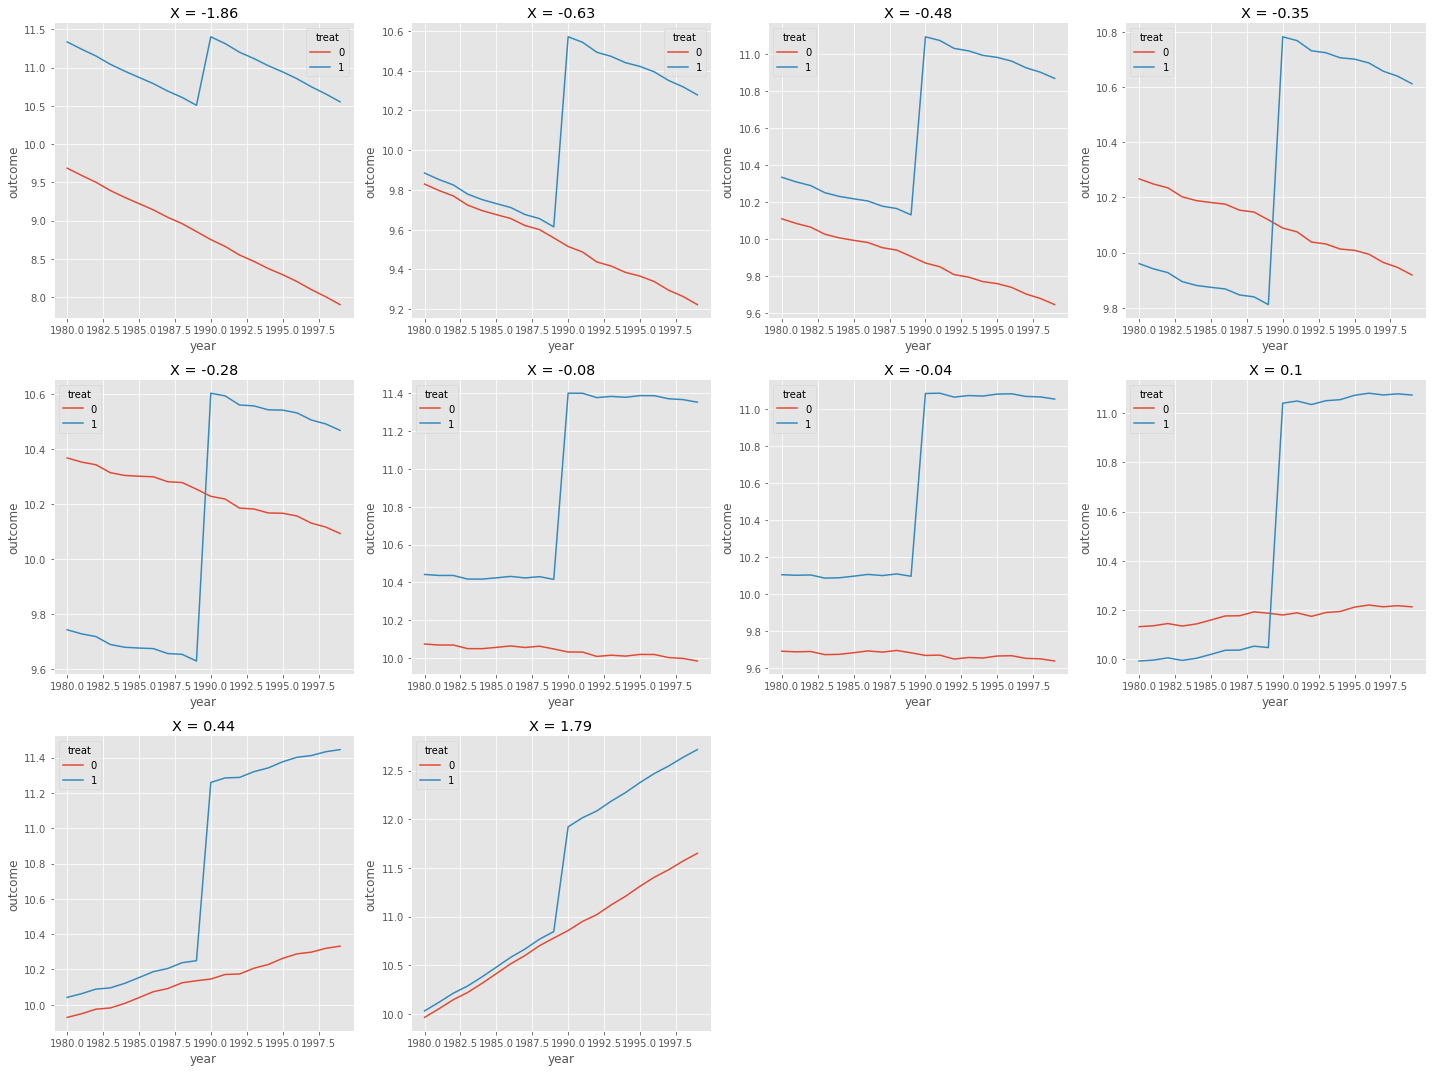

In [15]:
facet_col = "x"
all_facet_values = sorted(df_cov_trend[facet_col].unique())
g = sns.FacetGrid(df_cov_trend, col=facet_col, sharey=False, sharex=False, col_wrap=4, height=5, aspect=1)

for x, ax in zip(all_facet_values, g.axes):
    
    plot_df = df_cov_trend.query(f"{facet_col}=={x}")
    
    sns.lineplot(
        data=plot_df.groupby(["treat", "year"])["outcome"].mean().reset_index(),
        x="year",
        y = "outcome",
        hue="treat",
        ax=ax
    )
    
    ax.set_title(f"X = {round(x, 2)}")    

plt.tight_layout()

In [22]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

1.3052744446732731

In [23]:
formula = f"""outcome ~ treat:post + x * C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

0.9999999999999993

In [24]:
df_cov_trend.query("treat==1 & post==1")["tau"].mean()

1.0